## Simple ODE system

In [3]:
import deepxde as dde
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

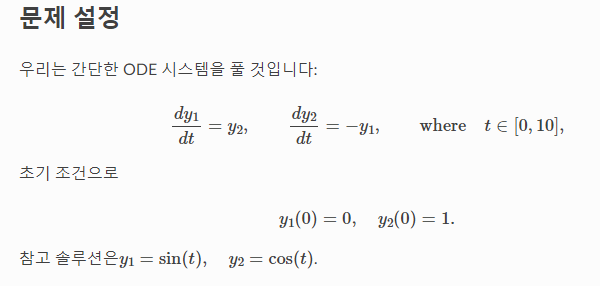

In [2]:
geom = dde.geometry.TimeDomain(0,10) # 시간 범위 지정

In [11]:
'''
# ODE 시스템을 해결하기 위해 각 변수의 변화율을 모델링해야 하기 떄문 변수를 분리한다
# 여러개의 종속변수가 있다면 각 변수에 대한 미분 방정식을 분리해야한다
'''

'\n# ODE 시스템을 해결하기 위해 각 변수의 변화율을 모델링해야 하기 떄문 변수를 분리한다\n# 여러개의 종속변수가 있다면 각 변수에 대한 미분 방정식을 분리해야한다\n'

In [8]:
def ode_system(x,y):
    y1,y2 = y[:,0:1],y[:,1:] 
    dy1_x = dde.grad.jacobian(y,x,i=0) #y1/x 
    dy2_x = dde.grad.jacobian(y,x,i=1) #y2/x
    return [dy1_x-y2 , dy2_x+y1]

# 경계조건 (이 문제에서는 없다)
def boundary(_, on_initial):
    return on_initial 

# 해를 나타냄 
def func(x):
    return np.hstack((np.sin(x), np.cos(x)))


geom = dde.geometry.TimeDomain(0,10)
# x=0에서 시작하므로 초기조건 설정 
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0) # x=0에서 y1=0 , componet는 y1에 대한것이라는걸 알려줌 
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1) # x=0에서 y2=1 , componet는 y2에 대한것이라는걸 알려줌
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100) # 35는 훈련개수 , 2는 종속변수 개수 

In [30]:
# 모델 
layer_size = [1] + [50] * 3 + [2] # 3개의 hidden layer 
activation = "tanh" # 활성화 함수는 tanh
initializer = "Glorot uniform" # initializer 
net = dde.nn.FNN(layer_size, activation, initializer) # model 구성 
model = dde.Model(data, net) # 
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.002544 s

Training model...

0         [1.95e-02, 1.76e-01, 0.00e+00, 1.00e+00]    [1.84e-02, 1.81e-01, 0.00e+00, 1.00e+00]    [1.04e+00]    
1000      [7.75e-03, 6.22e-03, 1.60e-10, 2.48e-04]    [8.49e-03, 6.14e-03, 1.60e-10, 2.48e-04]    [7.35e-01]    
2000      [4.80e-03, 4.03e-03, 6.61e-07, 1.02e-04]    [4.96e-03, 4.27e-03, 6.61e-07, 1.02e-04]    [5.75e-01]    
3000      [1.33e-03, 1.72e-03, 1.38e-06, 2.50e-05]    [1.42e-03, 1.51e-03, 1.38e-06, 2.50e-05]    [2.95e-01]    
4000      [3.05e-04, 5.04e-04, 7.75e-07, 3.42e-06]    [3.38e-04, 3.65e-04, 7.75e-07, 3.42e-06]    [1.21e-01]    
5000      [1.54e-04, 2.36e-04, 9.93e-06, 8.03e-06]    [1.64e-04, 1.73e-04, 9.93e-06, 8.03e-06]    [5.46e-02]    
6000      [4.82e-05, 7.92e-05, 5.65e-07, 2.34e-07]    [4.71e-05, 5.76e-05, 5.65e-07, 2.34e-07]    [2.82e-02]    
7000      [2.39e-05, 3.49e-05, 9.18e-07, 3.29e-07]    [2.47e-05, 2.48e-05, 9.18e-07, 3.29e-07]    [1.41e-02]    
8000      [1.24e-05, 1.47e-05, 

## torch로 바꿨을때